In [38]:
# 02_simple_baseline.ipynb
# Meta-Learning for Learned Indexes: Simple Baseline Implementation

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import time
from typing import Tuple, List
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 8)

print("✓ Imports successful")

✓ Imports successful


In [39]:
# ==============================================================================
# PART 1: LOAD DATASETS
# ==============================================================================

print("\\n" + "="*80)
print("LOADING DATASETS")
print("="*80)

import os

datasets = {}
dataset_names = ['linear', 'linear_noisy', 'quadratic', 'cubic',
                 'step', 'clustered', 'exponential']

for name in dataset_names:
    filepath = f'datasets/{name}_50k.csv'
    if os.path.exists(filepath):
        df = pd.read_csv(filepath)
        datasets[name] = (df['key'].values, df['position'].values)
        print(f"✓ Loaded {name}: {len(df)} records")
    else:
        print(f"✗ File not found: {filepath}")
        print(f"  Run 01_data_generation.ipynb first!")

print(f"\\n✓ Loaded {len(datasets)} datasets")

\n================================================================================
LOADING DATASETS
✓ Loaded linear: 50000 records
✓ Loaded linear_noisy: 50000 records
✓ Loaded quadratic: 50000 records
✓ Loaded cubic: 50000 records
✓ Loaded step: 50000 records
✓ Loaded clustered: 50000 records
✓ Loaded exponential: 50000 records
\n✓ Loaded 7 datasets


In [40]:
# ==============================================================================
# PART 2: OPTIMIZED LEARNED INDEX CLASS
# ==============================================================================

class SimpleLearnedIndex:
    """
    Optimized learned index with batch processing and direct array access.
    """
    
    def __init__(self):
        self.model = LinearRegression()
        self.keys = None
        self.positions = None
        self.is_trained = False
        
        # Performance tracking
        self.build_time = 0
        self.total_lookups = 0
        self.prediction_errors = []
        
    def build(self, keys: np.ndarray, positions: np.ndarray):
        """Build the learned index by training linear regression."""
        start_time = time.time()
        
        self.keys = keys
        self.positions = positions
        
        # Train linear regression
        X = keys.reshape(-1, 1)
        y = positions
        self.model.fit(X, y)
        self.is_trained = True
        
        self.build_time = time.time() - start_time
    
    def predict_positions_batch(self, keys_batch: np.ndarray) -> np.ndarray:
        """Predict positions for multiple keys at once (vectorized)."""
        if not self.is_trained:
            raise ValueError("Index not trained. Call build() first.")
        
        predictions = self.model.predict(keys_batch.reshape(-1, 1))
        # Clamp to valid range
        predictions = np.clip(predictions, 0, len(self.keys) - 1).astype(int)
        return predictions
    
    def exponential_search(self, key: float, predicted_pos: int) -> int:
        """
        Exponential search from predicted position.
        More efficient than binary search for small errors.
        """
        n = len(self.keys)
        
        # Check if prediction is exact
        if self.keys[predicted_pos] == key:
            return predicted_pos
        
        # Determine search direction
        if self.keys[predicted_pos] < key:
            # Search right
            step = 1
            while predicted_pos + step < n and self.keys[predicted_pos + step] < key:
                step *= 2
            
            # Binary search in found range
            left = predicted_pos + step // 2
            right = min(predicted_pos + step, n - 1)
        else:
            # Search left
            step = 1
            while predicted_pos - step >= 0 and self.keys[predicted_pos - step] > key:
                step *= 2
            
            # Binary search in found range
            left = max(predicted_pos - step, 0)
            right = predicted_pos - step // 2
        
        # Binary search in narrowed range
        while left <= right:
            mid = (left + right) // 2
            if self.keys[mid] == key:
                return mid
            elif self.keys[mid] < key:
                left = mid + 1
            else:
                right = mid - 1
        
        return -1
    
    def lookup_batch(self, search_keys: np.ndarray, error_bound: int = 5) -> Tuple[np.ndarray, dict]:
        """
        Batch lookup with optimized search strategy.
        
        Args:
            search_keys: Array of keys to search
            error_bound: If prediction error < this, use direct access
        
        Returns:
            positions: Array of found positions
            stats: Performance statistics
        """
        start_time = time.time()
        
        # Batch predict all positions
        predicted_positions = self.predict_positions_batch(search_keys)
        
        found_positions = np.zeros(len(search_keys), dtype=int)
        prediction_errors = []
        direct_hits = 0
        
        # Process each lookup
        for i, (key, pred_pos) in enumerate(zip(search_keys, predicted_positions)):
            # Try direct access first (if prediction is very close)
            if pred_pos < len(self.keys):
                # Check within small window for direct hit
                for offset in range(-error_bound, error_bound + 1):
                    check_pos = pred_pos + offset
                    if 0 <= check_pos < len(self.keys) and self.keys[check_pos] == key:
                        found_positions[i] = check_pos
                        direct_hits += 1
                        prediction_errors.append(abs(offset))
                        break
                else:
                    # If not found in window, use exponential search
                    pos = self.exponential_search(key, pred_pos)
                    found_positions[i] = pos if pos != -1 else -1
                    
                    # Calculate error
                    actual_pos = np.searchsorted(self.keys, key)
                    prediction_errors.append(abs(pred_pos - actual_pos))
            else:
                found_positions[i] = -1
                prediction_errors.append(0)
        
        total_time = time.time() - start_time
        
        self.prediction_errors.extend(prediction_errors)
        self.total_lookups += len(search_keys)
        
        stats = {
            'total_time_us': total_time * 1e6,
            'avg_time_per_lookup_us': (total_time / len(search_keys)) * 1e6,
            'direct_hit_rate': direct_hits / len(search_keys),
            'avg_prediction_error': np.mean(prediction_errors),
            'success_rate': np.sum(found_positions != -1) / len(search_keys)
        }
        
        return found_positions, stats
    
    def get_performance_summary(self) -> dict:
        """Get overall performance statistics."""
        if not self.prediction_errors:
            return {}
        
        errors = np.array(self.prediction_errors)
        
        return {
            'total_lookups': self.total_lookups,
            'build_time_ms': self.build_time * 1000,
            'avg_prediction_error': errors.mean(),
            'median_prediction_error': np.median(errors),
            'max_prediction_error': errors.max(),
            'std_prediction_error': errors.std(),
            '95th_percentile_error': np.percentile(errors, 95)
        }

print("\n✓ Optimized SimpleLearnedIndex class defined")


✓ Optimized SimpleLearnedIndex class defined


In [41]:
# ==============================================================================
# PART 3: TRADITIONAL BINARY SEARCH BASELINE (BATCHED)
# ==============================================================================

def binary_search_batch(keys: np.ndarray, search_keys: np.ndarray) -> Tuple[np.ndarray, float]:
    """
    Batched binary search for fair comparison.
    
    Returns:
        positions: Array of found positions
        total_time: Total time in microseconds
    """
    start_time = time.time()
    
    positions = np.zeros(len(search_keys), dtype=int)
    
    for i, search_key in enumerate(search_keys):
        left, right = 0, len(keys) - 1
        
        while left <= right:
            mid = (left + right) // 2
            
            if keys[mid] == search_key:
                positions[i] = mid
                break
            elif keys[mid] < search_key:
                left = mid + 1
            else:
                right = mid - 1
        else:
            positions[i] = -1
    
    total_time = (time.time() - start_time) * 1e6
    
    return positions, total_time

print("✓ Batched binary search baseline defined")

✓ Batched binary search baseline defined


In [42]:
# ==============================================================================
# PART 4: EVALUATE ON ALL DATASETS (OPTIMIZED)
# ==============================================================================

print("\n" + "="*80)
print("EVALUATING OPTIMIZED LEARNED INDEX")
print("="*80)

results = {}

for name, (keys, positions) in datasets.items():
    print(f"\nTesting on {name.upper()} dataset...")
    
    # Build learned index
    index = SimpleLearnedIndex()
    index.build(keys, positions)
    print(f"  Build time: {index.build_time*1000:.2f} ms")
    
    # Sample 10000 random keys for testing (larger batch for better stats)
    np.random.seed(42)
    test_indices = np.random.choice(len(keys), size=10000, replace=False)
    test_keys = keys[test_indices]
    
    # Test learned index (batched)
    found_pos_learned, stats_learned = index.lookup_batch(test_keys, error_bound=5)
    learned_avg_time = stats_learned['avg_time_per_lookup_us']
    
    # Test binary search baseline (batched)
    found_pos_binary, binary_total_time = binary_search_batch(keys, test_keys)
    binary_avg_time = binary_total_time / len(test_keys)
    
    # Get performance summary
    perf = index.get_performance_summary()
    
    results[name] = {
        'learned_avg_time': learned_avg_time,
        'binary_avg_time': binary_avg_time,
        'speedup': binary_avg_time / learned_avg_time,
        'success_rate': stats_learned['success_rate'],
        'direct_hit_rate': stats_learned['direct_hit_rate'],
        'avg_error': perf['avg_prediction_error'],
        'median_error': perf['median_prediction_error'],
        'max_error': perf['max_prediction_error'],
        '95th_error': perf['95th_percentile_error']
    }
    
    print(f"  Learned index: {learned_avg_time:.3f} μs per lookup")
    print(f"  Binary search: {binary_avg_time:.3f} μs per lookup")
    print(f"  Speedup: {results[name]['speedup']:.2f}x")
    print(f"  Direct hit rate: {stats_learned['direct_hit_rate']*100:.1f}%")
    print(f"  Avg prediction error: {perf['avg_prediction_error']:.1f} positions")
    print(f"  Success rate: {stats_learned['success_rate']*100:.1f}%")

print("\n✓ Evaluation complete!")


EVALUATING OPTIMIZED LEARNED INDEX

Testing on LINEAR dataset...
  Build time: 2.27 ms
  Learned index: 1.797 μs per lookup
  Binary search: 2.694 μs per lookup
  Speedup: 1.50x
  Direct hit rate: 100.0%
  Avg prediction error: 0.5 positions
  Success rate: 100.0%

Testing on LINEAR_NOISY dataset...
  Build time: 1.60 ms
  Learned index: 1.810 μs per lookup
  Binary search: 2.474 μs per lookup
  Speedup: 1.37x
  Direct hit rate: 100.0%
  Avg prediction error: 1.0 positions
  Success rate: 100.0%

Testing on QUADRATIC dataset...
  Build time: 1.46 ms
  Learned index: 9.937 μs per lookup
  Binary search: 2.453 μs per lookup
  Speedup: 0.25x
  Direct hit rate: 0.1%
  Avg prediction error: 2890.0 positions
  Success rate: 100.0%

Testing on CUBIC dataset...
  Build time: 1.23 ms
  Learned index: 9.560 μs per lookup
  Binary search: 2.446 μs per lookup
  Speedup: 0.26x
  Direct hit rate: 0.1%
  Avg prediction error: 4644.5 positions
  Success rate: 100.0%

Testing on STEP dataset...
  Buil

\n================================================================================
VISUALIZING RESULTS
\n✓ Saved: baseline_performance.png


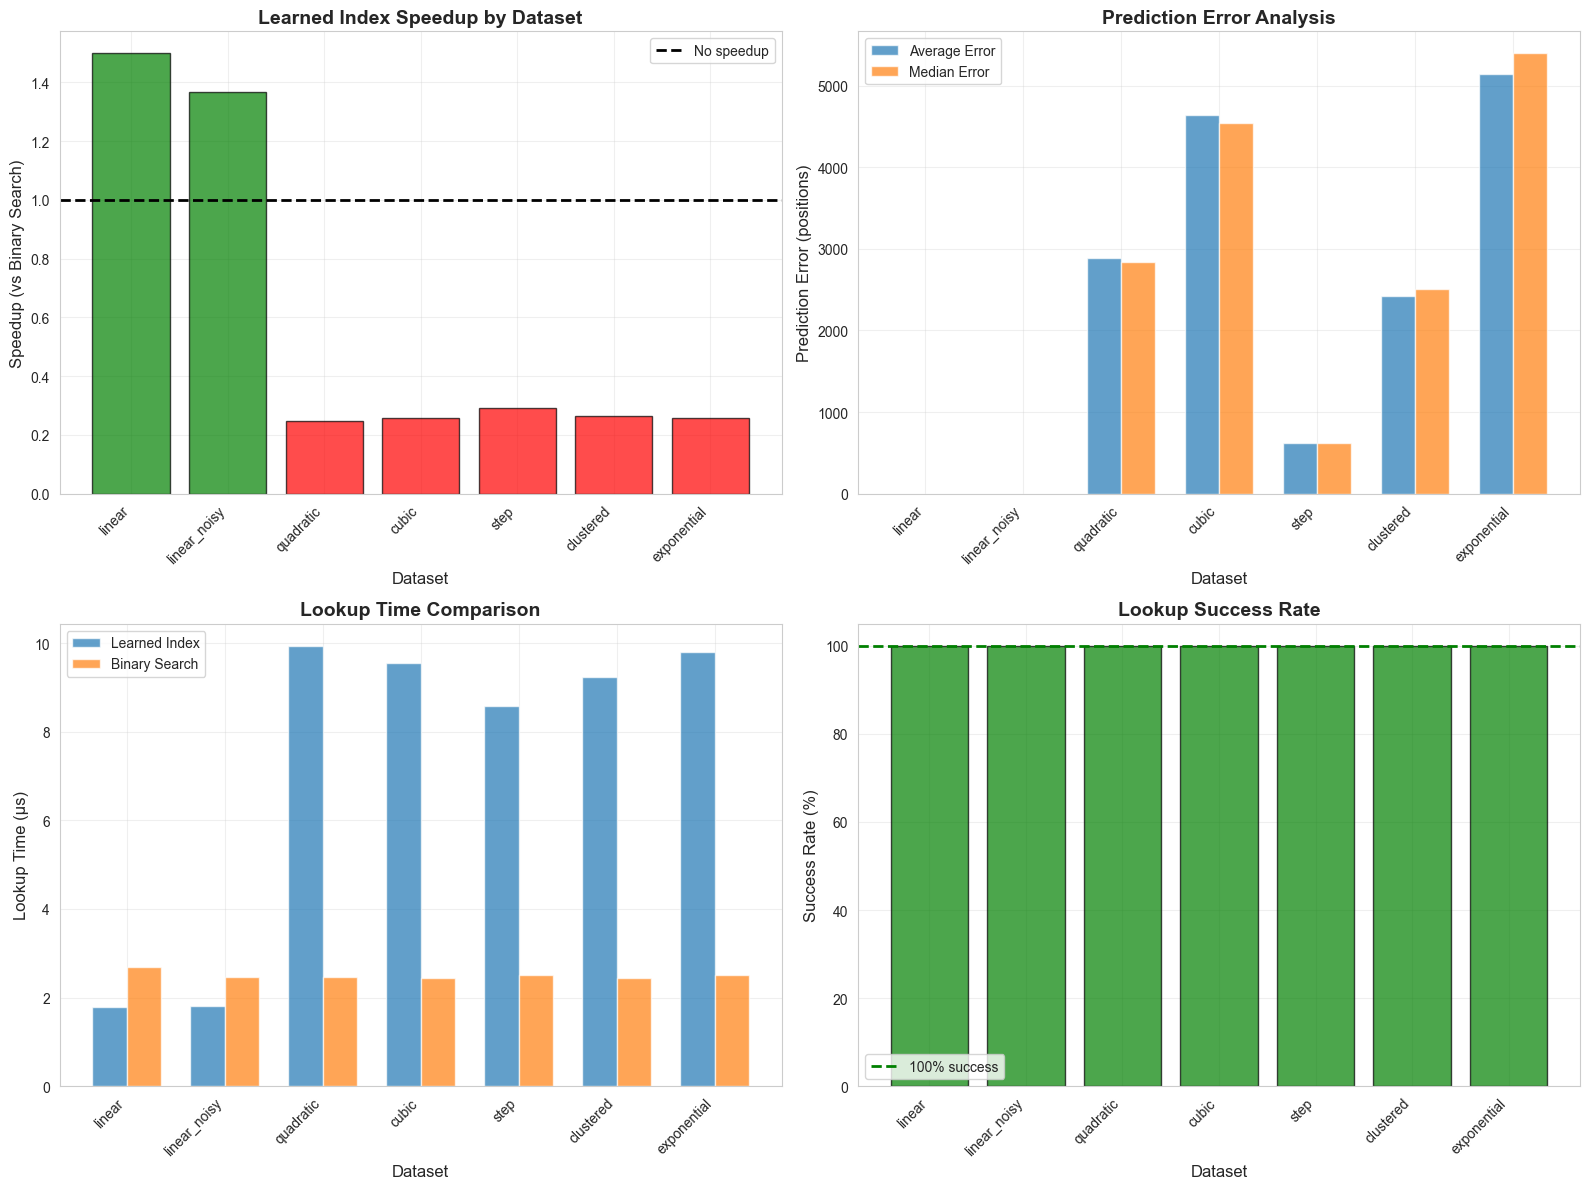

In [43]:
# ==============================================================================
# PART 5: RESULTS VISUALIZATION
# ==============================================================================

print("\\n" + "="*80)
print("VISUALIZING RESULTS")
print("="*80)

# Create summary DataFrame
results_df = pd.DataFrame(results).T
results_df['dataset'] = results_df.index

# Plot 1: Speedup comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Speedup bar chart
ax1 = axes[0, 0]
colors = ['green' if x > 1 else 'red' for x in results_df['speedup']]
ax1.bar(results_df['dataset'], results_df['speedup'], color=colors, alpha=0.7, edgecolor='black')
ax1.axhline(y=1, color='black', linestyle='--', linewidth=2, label='No speedup')
ax1.set_xlabel('Dataset', fontsize=12)
ax1.set_ylabel('Speedup (vs Binary Search)', fontsize=12)
ax1.set_title('Learned Index Speedup by Dataset', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Prediction error comparison
ax2 = axes[0, 1]
x = np.arange(len(results_df))
width = 0.35
ax2.bar(x - width/2, results_df['avg_error'], width, label='Average Error', alpha=0.7)
ax2.bar(x + width/2, results_df['median_error'], width, label='Median Error', alpha=0.7)
ax2.set_xlabel('Dataset', fontsize=12)
ax2.set_ylabel('Prediction Error (positions)', fontsize=12)
ax2.set_title('Prediction Error Analysis', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(results_df['dataset'])
ax2.legend()
ax2.grid(True, alpha=0.3)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Lookup time comparison
ax3 = axes[1, 0]
x = np.arange(len(results_df))
width = 0.35
ax3.bar(x - width/2, results_df['learned_avg_time'], width, label='Learned Index', alpha=0.7)
ax3.bar(x + width/2, results_df['binary_avg_time'], width, label='Binary Search', alpha=0.7)
ax3.set_xlabel('Dataset', fontsize=12)
ax3.set_ylabel('Lookup Time (μs)', fontsize=12)
ax3.set_title('Lookup Time Comparison', fontsize=14, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(results_df['dataset'])
ax3.legend()
ax3.grid(True, alpha=0.3)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Success rate
ax4 = axes[1, 1]
success_pct = results_df['success_rate'] * 100
colors = ['green' if x >= 95 else 'orange' if x >= 80 else 'red' for x in success_pct]
ax4.bar(results_df['dataset'], success_pct, color=colors, alpha=0.7, edgecolor='black')
ax4.axhline(y=100, color='green', linestyle='--', linewidth=2, label='100% success')
ax4.set_xlabel('Dataset', fontsize=12)
ax4.set_ylabel('Success Rate (%)', fontsize=12)
ax4.set_title('Lookup Success Rate', fontsize=14, fontweight='bold')
ax4.set_ylim([0, 105])
ax4.legend()
ax4.grid(True, alpha=0.3)
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('baseline_performance.png', dpi=150, bbox_inches='tight')
print("\\n✓ Saved: baseline_performance.png")
plt.show()


DETAILED PREDICTION ANALYSIS

Detailed analysis on LINEAR dataset...

✓ Saved: prediction_analysis_detail.png


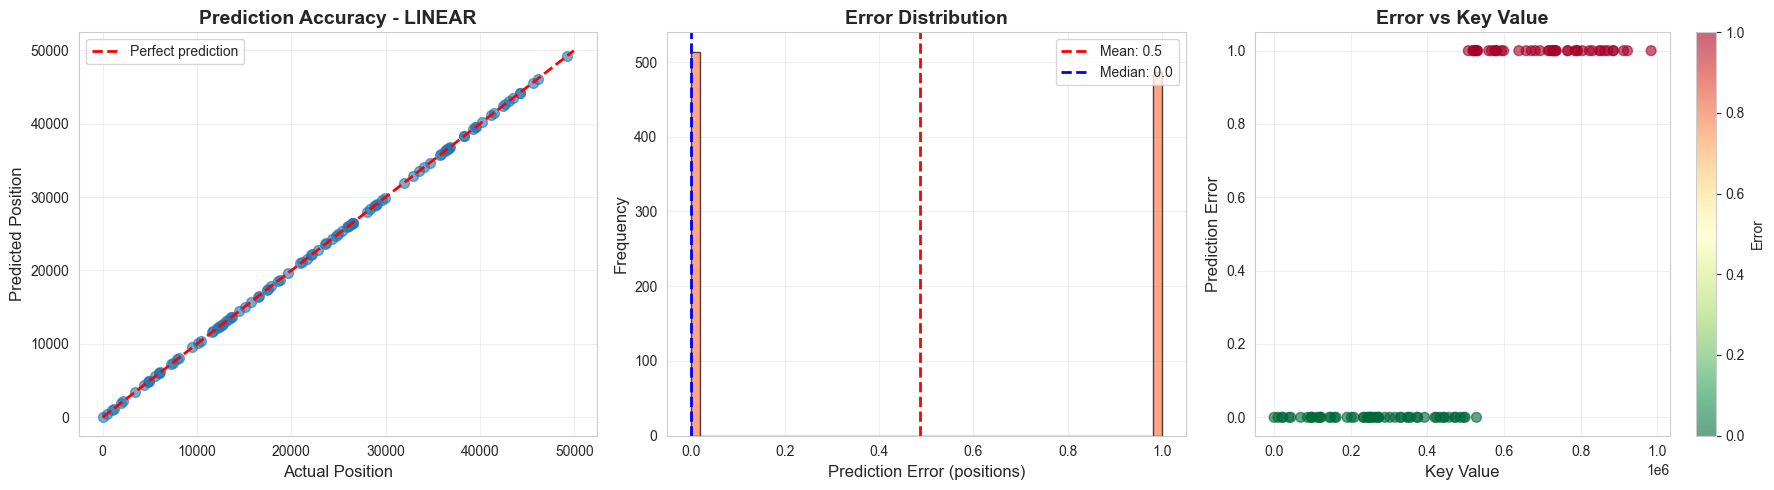


Prediction Statistics for LINEAR:
  Mean Error: 0.49 positions
  Median Error: 0.00 positions
  Max Error: 1 positions
  95th Percentile: 1.00 positions
  Errors <= 5 positions: 100.0%


In [44]:
# ==============================================================================
# PART 6: DETAILED PREDICTION ANALYSIS
# ==============================================================================

print("\n" + "="*80)
print("DETAILED PREDICTION ANALYSIS")
print("="*80)

# Test one dataset in detail to understand prediction behavior
test_dataset_name = 'linear'
test_keys, test_positions = datasets[test_dataset_name]

print(f"\nDetailed analysis on {test_dataset_name.upper()} dataset...")

# Build index
detail_index = SimpleLearnedIndex()
detail_index.build(test_keys, test_positions)

# Sample keys
np.random.seed(42)
sample_size = 1000
sample_indices = np.random.choice(len(test_keys), size=sample_size, replace=False)
sample_keys = test_keys[sample_indices]

# Use batch lookup to get predictions
predicted_positions = detail_index.predict_positions_batch(sample_keys)

# Calculate actual positions and errors
predictions = []
actuals = []
errors = []

for i, key in enumerate(sample_keys):
    actual_pos = np.searchsorted(test_keys, key)
    pred_pos = predicted_positions[i]
    
    predictions.append(pred_pos)
    actuals.append(actual_pos)
    errors.append(abs(pred_pos - actual_pos))

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Predicted vs Actual
ax1 = axes[0]
ax1.scatter(actuals[::10], predictions[::10], alpha=0.6, s=50)
ax1.plot([0, max(actuals)], [0, max(actuals)], 'r--', linewidth=2, label='Perfect prediction')
ax1.set_xlabel('Actual Position', fontsize=12)
ax1.set_ylabel('Predicted Position', fontsize=12)
ax1.set_title(f'Prediction Accuracy - {test_dataset_name.upper()}', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Error distribution
ax2 = axes[1]
ax2.hist(errors, bins=50, edgecolor='black', alpha=0.7, color='coral')
ax2.axvline(np.mean(errors), color='red', linestyle='--', linewidth=2,
            label=f'Mean: {np.mean(errors):.1f}')
ax2.axvline(np.median(errors), color='blue', linestyle='--', linewidth=2,
            label=f'Median: {np.median(errors):.1f}')
ax2.set_xlabel('Prediction Error (positions)', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('Error Distribution', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Error over key range
ax3 = axes[2]
scatter = ax3.scatter(sample_keys[::10], np.array(errors)[::10], 
                     alpha=0.6, s=50, c=np.array(errors)[::10], 
                     cmap='RdYlGn_r', vmin=0, vmax=max(errors))
ax3.set_xlabel('Key Value', fontsize=12)
ax3.set_ylabel('Prediction Error', fontsize=12)
ax3.set_title('Error vs Key Value', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax3, label='Error')

plt.tight_layout()
plt.savefig('prediction_analysis_detail.png', dpi=150, bbox_inches='tight')
print("\n✓ Saved: prediction_analysis_detail.png")
plt.show()

print(f"\nPrediction Statistics for {test_dataset_name.upper()}:")
print(f"  Mean Error: {np.mean(errors):.2f} positions")
print(f"  Median Error: {np.median(errors):.2f} positions")
print(f"  Max Error: {np.max(errors):.0f} positions")
print(f"  95th Percentile: {np.percentile(errors, 95):.2f} positions")
print(f"  Errors <= 5 positions: {np.sum(np.array(errors) <= 5) / len(errors) * 100:.1f}%")

In [45]:
# ==============================================================================
# PART 7: SUMMARY TABLE
# ==============================================================================

print("\\n" + "="*80)
print("PERFORMANCE SUMMARY TABLE")
print("="*80)

summary_df = pd.DataFrame({
    'Dataset': results_df['dataset'],
    'Learned (μs)': results_df['learned_avg_time'].round(2),
    'Binary (μs)': results_df['binary_avg_time'].round(2),
    'Speedup': results_df['speedup'].round(2),
    'Avg Error': results_df['avg_error'].round(1),
    'Max Error': results_df['max_error'].round(1),
    'Success %': (results_df['success_rate'] * 100).round(1)
})

print("\\n", summary_df.to_string(index=False))

\n================================================================================
PERFORMANCE SUMMARY TABLE
\n      Dataset  Learned (μs)  Binary (μs)  Speedup  Avg Error  Max Error  Success %
      linear          1.80         2.69     1.50        0.5        1.0      100.0
linear_noisy          1.81         2.47     1.37        1.0        5.0      100.0
   quadratic          9.94         2.45     0.25     2890.0     9370.0      100.0
       cubic          9.56         2.45     0.26     4644.5    13328.0      100.0
        step          8.58         2.51     0.29      615.0     1374.0      100.0
   clustered          9.23         2.44     0.26     2416.6     4492.0      100.0
 exponential          9.79         2.52     0.26     5139.5    12458.0      100.0


In [46]:
# ==============================================================================
# PART 8: KEY INSIGHTS
# ==============================================================================

print("\\n" + "="*80)
print("KEY INSIGHTS")
print("="*80)

# Find best and worst performing datasets
best_speedup = summary_df.loc[summary_df['Speedup'].idxmax()]
worst_speedup = summary_df.loc[summary_df['Speedup'].idxmin()]
lowest_error = summary_df.loc[summary_df['Avg Error'].idxmin()]
highest_error = summary_df.loc[summary_df['Avg Error'].idxmax()]

print(f"\\n✓ BEST SPEEDUP: {best_speedup['Dataset']} ({best_speedup['Speedup']:.2f}x)")
print(f"  - This pattern is ideal for simple linear regression")
print(f"  - Average error: {best_speedup['Avg Error']:.1f} positions")

print(f"\\n✗ WORST SPEEDUP: {worst_speedup['Dataset']} ({worst_speedup['Speedup']:.2f}x)")
print(f"  - This pattern is challenging for linear models")
print(f"  - Average error: {worst_speedup['Avg Error']:.1f} positions")

print(f"\\n✓ LOWEST ERROR: {lowest_error['Dataset']} ({lowest_error['Avg Error']:.1f} positions)")
print(f"  - Linear regression fits this pattern very well")

print(f"\\n✗ HIGHEST ERROR: {highest_error['Dataset']} ({highest_error['Avg Error']:.1f} positions)")
print(f"  - This pattern needs a more sophisticated model")

print("\\n" + "-"*80)
print("CONCLUSIONS:")
print("-"*80)

avg_speedup = summary_df['Speedup'].mean()
if avg_speedup > 1:
    print(f"\\n✓ Overall: Learned index is {avg_speedup:.2f}x faster on average!")
else:
    print(f"\\n✗ Overall: Binary search is faster (learned index {avg_speedup:.2f}x)")

print("\\n📊 Pattern-specific insights:")
patterns_with_speedup = summary_df[summary_df['Speedup'] > 1]
patterns_without_speedup = summary_df[summary_df['Speedup'] <= 1]

if len(patterns_with_speedup) > 0:
    print(f"  • {len(patterns_with_speedup)}/{len(summary_df)} patterns benefit from learned index")
    print(f"  • Works well on: {', '.join(patterns_with_speedup['Dataset'].tolist())}")

if len(patterns_without_speedup) > 0:
    print(f"  • {len(patterns_without_speedup)}/{len(summary_df)} patterns don't benefit")
    print(f"  • Struggles with: {', '.join(patterns_without_speedup['Dataset'].tolist())}")

print("\\n💡 This is why we need ADAPTIVE MODEL SELECTION:")
print("  • One model doesn't work well for all patterns")
print("  • Different patterns need different models")
print("  • Meta-learning can choose the right model for each pattern")

print("\\n" + "="*80)
print("BASELINE EVALUATION COMPLETE!")
print("="*80)
print("\\nNext steps:")
print("1. Review which patterns work well vs poorly")
print("2. Move to 03_feature_extraction.ipynb")
print("3. Extract features that distinguish these patterns")
print("4. Build meta-learner to select models adaptively")
print("="*80)

# Save results for later use
summary_df.to_csv('baseline_results.csv', index=False)
print("\\n✓ Saved results to baseline_results.csv")

\n================================================================================
KEY INSIGHTS
\n✓ BEST SPEEDUP: linear (1.50x)
  - This pattern is ideal for simple linear regression
  - Average error: 0.5 positions
\n✗ WORST SPEEDUP: quadratic (0.25x)
  - This pattern is challenging for linear models
  - Average error: 2890.0 positions
\n✓ LOWEST ERROR: linear (0.5 positions)
  - Linear regression fits this pattern very well
\n✗ HIGHEST ERROR: exponential (5139.5 positions)
  - This pattern needs a more sophisticated model
\n--------------------------------------------------------------------------------
CONCLUSIONS:
--------------------------------------------------------------------------------
\n✗ Overall: Binary search is faster (learned index 0.60x)
\n📊 Pattern-specific insights:
  • 2/7 patterns benefit from learned index
  • Works well on: linear, linear_noisy
  • 5/7 patterns don't benefit
  • Struggles with: quadratic, cubic, step, clustered, exponential
\n💡 This is why we n